## Data

The animal audiograms database contains [69 audiograms](https://animalaudiograms.museumfuernaturkunde.berlin//advanced?order_by=vernacular_name_english&species=851318&taxon=851318&method=&publication=&facility=&from=&to=&medium=water&sex=&liberty=&lifestage=&duration_in_captivity_from=&duration_in_captivity_to=&sedated=&age_from=&age_to=&position=&distance_from=&distance_to=&threshold_from=&threshold_to=&tone=&staircase=&form=&constants=) of a belugas in water.

The audiograms for the belugas were downloaded and stored in the file `data/Delphinapterus_leucas.csv`. 

In [297]:
# import the FFT scripts
source("FFT.R")

In [256]:
# Read the downloaded data
data_file <- "./data/Delphinapterus_leucas.csv"
audiogram <- read.table(data_file, header=TRUE, sep=",")

## Computing the effective hearing range
The data can now be loaded to estimate the functional hearing range, i.e. the lowest and highest frequency that caused a measurable response in any audiogram of this species.

[1] "lowest frequency in effective hearing range: 0.13 kHz"
[1] "highest frequency in effective hearing range: 150 kHz"


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



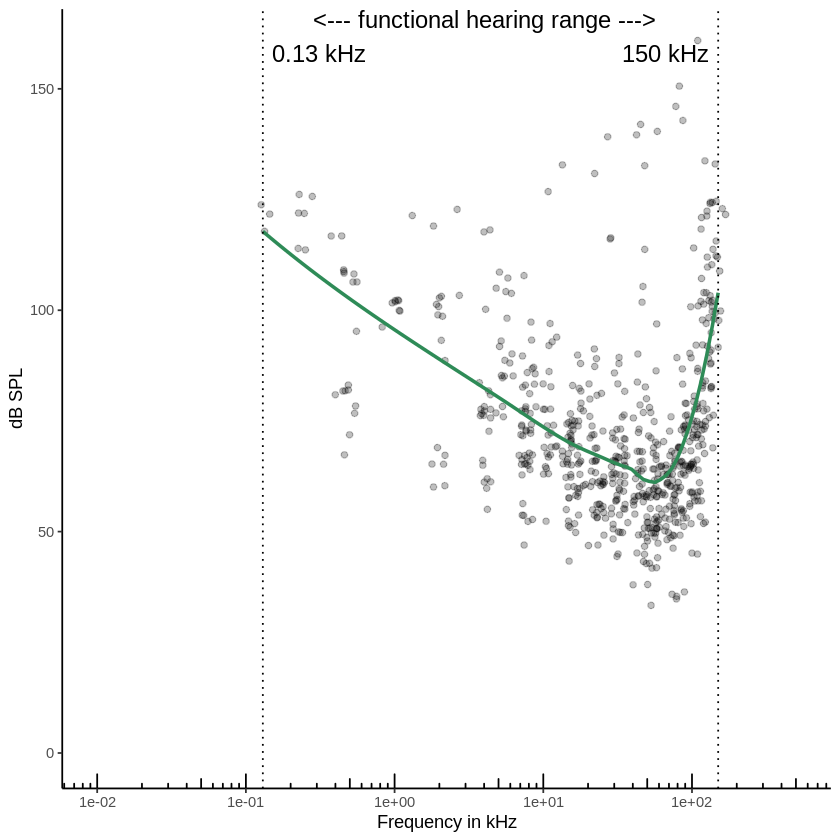

In [298]:
# compute the functional hearing frequency range
range <- def.f.range(audiogram)

print(paste("lowest frequency in effective hearing range:",range$eff.freq.low, "kHz"))
print(paste("highest frequency in effective hearing range:", round(range$eff.freq.high), "kHz"))

# plot the data, the fit curve, and the effective hearing range
plot.effective(audiogram, range)

## Defining the filter values
Filter weights are computed by applying the M-weighting function described in Southall et al. (2007), appendix A, p. 500

Frequency.in.kHz,Gain.in.dB
<dbl>,<dbl>
0.02000000,-75.30433712
0.04397048,-45.49139730
0.09667017,-20.61691293
0.21253171,-6.32105748
0.46725612,-1.45571909
1.02727387,-0.28308313
2.25848647,-0.03508068
4.96533715,0.00000000
10.91641386,-0.07287589


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



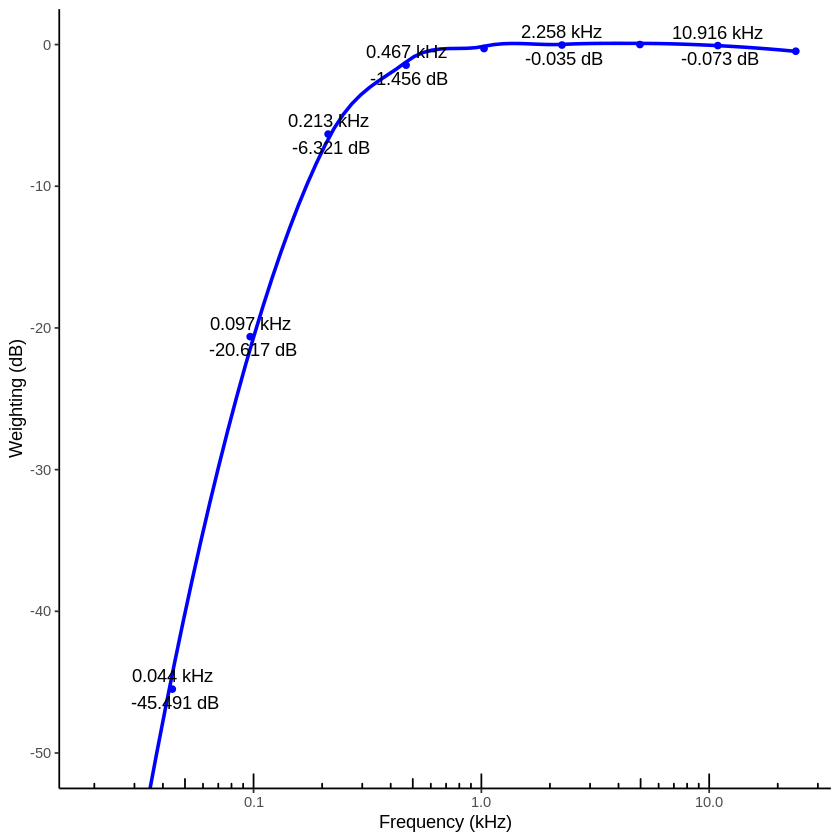

In [294]:
# filter frequencies from 20Hz to 24kHz
seq <- make.f.seq(0.02, 24)

M.table <- make.M.table(seq, range$eff.freq.low, range$eff.freq.high)
M.table

plot.M(M.table, TRUE)


## Implement the filter
Implement a filter using the values from table above. Q is set to 1.414 (1 octave) for a smoother filter curve. The filtered sound s normalized at -3dB.

The generated command can be used to invoque sox by copy-pasting it in a Linux terminal.

In [299]:
# sox command
inputfile <- "data/whitenoise.wav"
outputfile <- "data/M.ft_Delphinapterus_leucas.mp3"
Q <- 1.414
command <- sox_command(inputfile, outputfile, M.table, Q)
command

[1] "sox data/whitenoise.wav data/M.ft_Delphinapterus_leucas.mp3 equalizer 20 1.414 -75.3043371175749 equalizer 43.9704839121896 1.414 -45.4913973026114 equalizer 96.6701727736063 1.414 -20.6169129275007 equalizer 212.531713836522 1.414 -6.3210574844503 equalizer 467.256115203944 1.414 -1.4557190861687 equalizer 1027.27387482236 1.414 -0.283083128904018 equalizer 2258.48646931447 1.414 -0.0350806777448934 equalizer 4965.33714824449 1.414 0 equalizer 10916.4138597741 1.414 -0.0728758878783705 norm -3"